* * *
<pre> NYU Paris            <i> Artificial intelligence - Fall 2023 </i></pre>
* * *


<h1 align="center"> Assignment 1 solutions: Model complexity and model selection </h1>

<pre align="left"> September 28th 2023               <i> Author: Hicham Janati </i></pre>
* * *


##### Goals:
- Know when the model underfits and overfits and act accordingly
- Perform hyperparameter tuning using cross validation
- Use scikit-learn pipelines to streamline machine learning steps

## 1 - Reading and visualizing data 


First we load a dataset of images of famous persons and visualize some examples.

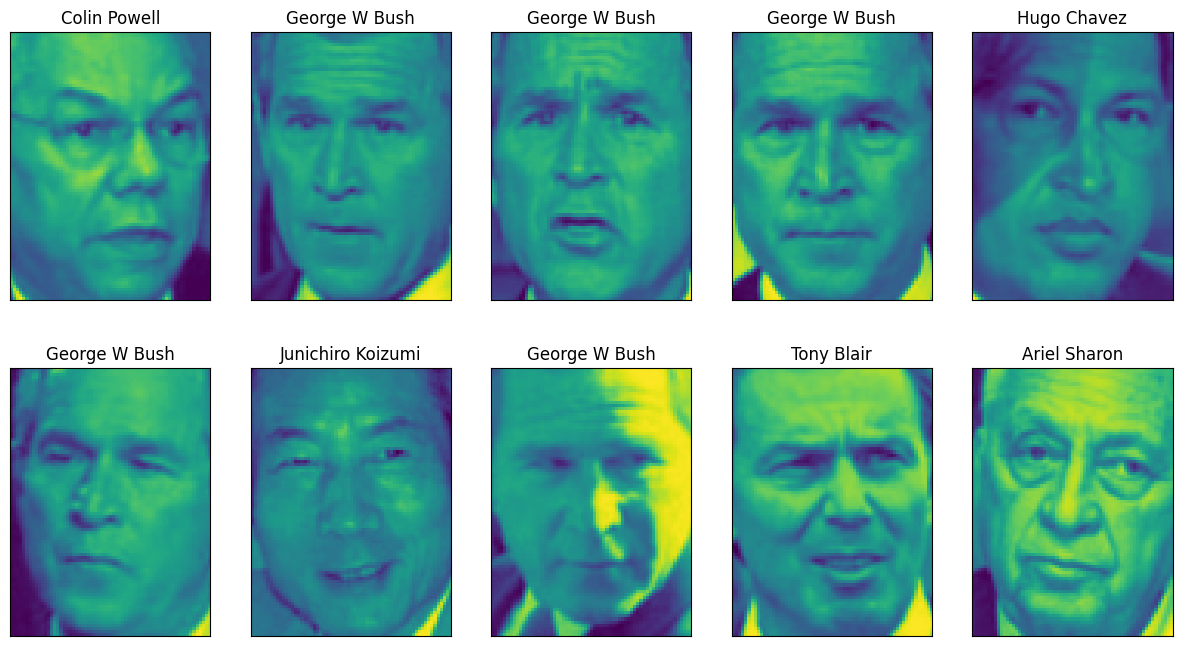

In [1]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
people = fetch_lfw_people(min_faces_per_person=60, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

Some information about the dataset can be obtained by getting the documentation of the fetch function:

In [2]:
help(fetch_lfw_people)

Help on function fetch_lfw_people in module sklearn.datasets._lfw:

fetch_lfw_people(*, data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)
    Load the Labeled Faces in the Wild (LFW) people dataset (classification).
    
    Download it if necessary.
    
    =================   =======================
    Classes                                5749
    Samples total                         13233
    Dimensionality                         5828
    Features            real, between 0 and 255
    =================   =======================
    
    Read more in the :ref:`User Guide <labeled_faces_in_the_wild_dataset>`.
    
    Parameters
    ----------
    data_home : str, default=None
        Specify another download and cache folder for the datasets. By default
        all scikit-learn data is stored in '~/scikit_learn_data' subfolders.
    
    funneled : boo

We print data shapes info:

In [3]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (1348, 87, 65)
Number of classes: 8


We have 8 different persons in the dataset with a total of 1348 images of shape (87x65).

### Question 0
Count how many each person appears in the dataset. 

Hint: Look up the function `np.bincount`

In [4]:
import numpy as np
# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count))

Ariel Sharon               77
Colin Powell              236
Donald Rumsfeld           121
George W Bush             530
Gerhard Schroeder         109
Hugo Chavez                71
Junichiro Koizumi          60
Tony Blair                144


We reshape the images the dataset to be of the form (n_samples x n_features)

In [5]:
X = people.images.reshape(len(people.images), -1)
y = people.target
X.min(), X.max(), X[0]

(0.0,
 255.0,
 array([136.33333  , 134.66667  , 131.66667  , ...,   2.6666667,
          1.6666666,   0.6666667], dtype=float32))

The image values are between 0 and 255. We rescale them to 0-1.

In [6]:
X = X / 255

### Question 1
Split the dataset into train and test (80% train). Look up the documentation of `train_test_split` to make sure the frequency of each label is respected in the splits. If you wrote a naive classifier that predicts the target of the person by picking a number randomly (uniformly). What would be its prediction score ? 

This would be our score baseline i.e the performance of chance.


<font color="green"> By predicting randomly one of the 8 possible labels, the model would be right 1/8 of the time, having thus an accuracy of 0.125 </font>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, test_size=0.2)


### Question 2

We start with making predictions with a K-nearest-neighbors (kNN) model. KNN predicts the target (the identity of the person) based on the majority vote of the target of the K closest images to it. Here we define "close" by computing a simple squared euclidean distance between the images.

Fit a k-NN with k [1, 2, 3, 4, 5] and compute its prediction score for train and test. How do you explain this result ? Does it overfit or underfit ?

In [8]:
from sklearn.neighbors import KNeighborsClassifier

for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    print(f"Train set score of {k}-nn: {knn.score(X_train, y_train)}")
    print(f"Test set score of {k}-nn: {knn.score(X_test, y_test)}")

Train set score of 1-nn: 1.0
Test set score of 1-nn: 0.5407407407407407
Train set score of 2-nn: 0.7894248608534323
Test set score of 2-nn: 0.5037037037037037
Train set score of 3-nn: 0.7680890538033395
Test set score of 3-nn: 0.5666666666666667
Train set score of 4-nn: 0.7402597402597403
Test set score of 4-nn: 0.5851851851851851
Train set score of 5-nn: 0.738404452690167
Test set score of 5-nn: 0.5925925925925926


<font color="green"> A model overfits when It does super well on the train test (perfect score) but poorly on a the test set. In this case, we say that it cannot generalize. 
Ignoring the trivial K=1 case, we can clearly see that the train score is far from perfect i.e the model complexity is not enough to even learn the data it had already seen: underfitting. </font>

<font color="blue"> Remark: even though it can also be said that the test score is significantly lower than the train score (poor generalization), in practice as a machine learning you would need to add more complexity to your model in this case to first have a better train score. </font>.

### Question
Display its train and test accuracy as a function of the n_train_samples. 

In [9]:
train_scores, test_scores = [], []
ns = np.arange(3, len(X_train), 50)

for n in ns:
    knn = KNeighborsClassifier(3)
    knn.fit(X_train[:n], y_train[:n])
    score_train, score_test = knn.score(X_train[:n], y_train[:n]), knn.score(X_test, y_test)
    train_scores.append(score_train)
    test_scores.append(score_test)


[]

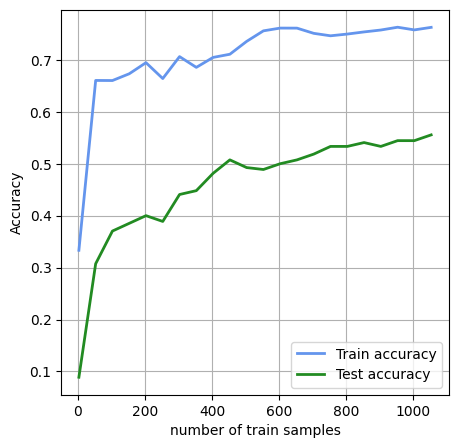

In [10]:
plt.figure(figsize=(5, 5))
plt.plot(ns, train_scores, color="cornflowerblue", label="Train accuracy", lw=2)
plt.plot(ns, test_scores, color="forestgreen", label="Test accuracy", lw=2)
plt.legend()
plt.xlabel("number of train samples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.plot()

### Question 3
Compute knn scores but this time do a PCA before to reduce the dimensionality of the data to 100 components

In [11]:
from sklearn.decomposition import PCA

pca = PCA(100)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca_train, y_train)
    print(f"Train set score of {k}-nn: {knn.score(X_pca_train, y_train)}")
    print(f"Test set score of {k}-nn: {knn.score(X_pca_test, y_test)}")

Train set score of 1-nn: 1.0
Test set score of 1-nn: 0.5296296296296297
Train set score of 2-nn: 0.787569573283859
Test set score of 2-nn: 0.5074074074074074
Train set score of 3-nn: 0.7606679035250464
Test set score of 3-nn: 0.5703703703703704
Train set score of 4-nn: 0.7411873840445269
Test set score of 4-nn: 0.5481481481481482
Train set score of 5-nn: 0.7300556586270872
Test set score of 5-nn: 0.5555555555555556


In [12]:
from sklearn.decomposition import PCA

pca = PCA(100)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

train_scores_pca, test_scores_pca = [], []
ns = np.arange(3, len(X_train_pca), 50)

for n in ns:
    knn = KNeighborsClassifier(3)
    knn.fit(X_train_pca[:n], y_train[:n])
    score_train, score_test = knn.score(X_train_pca[:n], y_train[:n]), knn.score(X_test_pca, y_test)
    train_scores_pca.append(score_train)
    test_scores_pca.append(score_test)



[]

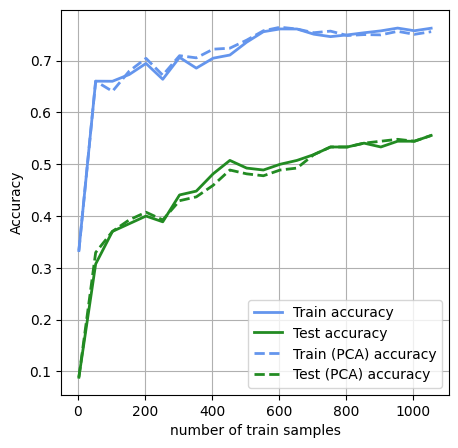

In [13]:
plt.figure(figsize=(5, 5))
plt.plot(ns, train_scores, color="cornflowerblue", label="Train accuracy", lw=2)
plt.plot(ns, test_scores, color="forestgreen", label="Test accuracy", lw=2)
plt.plot(ns, train_scores_pca, color="cornflowerblue", ls="--", label="Train (PCA) accuracy", lw=2)
plt.plot(ns, test_scores_pca, color="forestgreen", ls="--", label="Test (PCA) accuracy", lw=2)
plt.legend()
plt.xlabel("number of train samples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.plot()

### Question 4 
Repeat this operation but set the PCA argument `whiten` to True. What do you notice ? How do you explain it ?

In [14]:
from sklearn.decomposition import PCA

pca = PCA(100, whiten=True)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_pca_train, y_train)
    print(f"Test set score of {k}-nn: {knn.score(X_pca_test, y_test)}")

Test set score of 1-nn: 0.6814814814814815
Test set score of 2-nn: 0.5814814814814815
Test set score of 3-nn: 0.6555555555555556
Test set score of 4-nn: 0.6962962962962963
Test set score of 5-nn: 0.674074074074074


In [15]:
from sklearn.decomposition import PCA

pca = PCA(100, whiten=True)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

train_scores_pca, test_scores_pca = [], []
ns = np.arange(3, len(X_train_pca), 50)

for n in ns:
    knn = KNeighborsClassifier(3)
    knn.fit(X_train_pca[:n], y_train[:n])
    score_train, score_test = knn.score(X_train_pca[:n], y_train[:n]), knn.score(X_test_pca, y_test)
    train_scores_pca.append(score_train)
    test_scores_pca.append(score_test)



[]

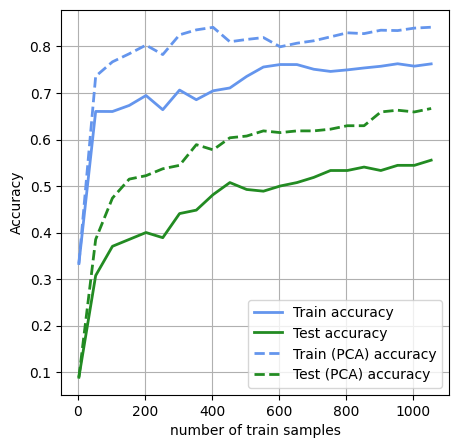

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(ns, train_scores, color="cornflowerblue", label="Train accuracy", lw=2)
plt.plot(ns, test_scores, color="forestgreen", label="Test accuracy", lw=2)
plt.plot(ns, train_scores_pca, color="cornflowerblue", ls="--", label="Train (PCA) accuracy", lw=2)
plt.plot(ns, test_scores_pca, color="forestgreen", ls="--", label="Test (PCA) accuracy", lw=2)
plt.legend()
plt.xlabel("number of train samples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.plot()

<font color="green"> Using `whiten=true` with PCA makes the model significantly better as components are now "whitened" a.k.a denoised and have equal importance. Decorrelating variables (features) is sometimes beneficial. </font>

### Question 5
Look up the attributes of the PCA object and visualize the first 10 components (as images).

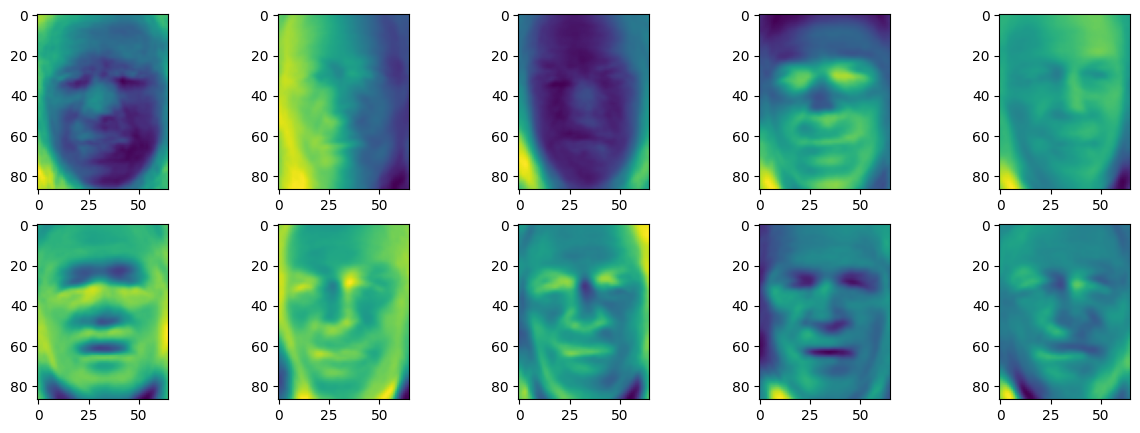

In [17]:
f, axes = plt.subplots(2, 5, figsize=(15, 5))
for ax, comp in zip(axes.ravel(), pca.components_):  
    ax.imshow(comp.reshape(people.images[0].shape))
plt.show()

<font color="green"> The PCA components are the new "features" in our X_pca dataset. Now each image has coordinates in this new basis. You can see how each component captures a specific characteristic of the face </font>

### Question 6
We can automatize the choice of K by performing cross-validation:

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
params = {'n_neighbors': [2, 5, 10]}
clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

y_pred = clf.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.31      0.37        16
           1       0.48      0.70      0.57        47
           2       1.00      0.29      0.45        24
           3       0.56      0.87      0.68       106
           4       0.00      0.00      0.00        22
           5       0.20      0.07      0.11        14
           6       0.86      0.50      0.63        12
           7       0.71      0.17      0.28        29

    accuracy                           0.55       270
   macro avg       0.53      0.36      0.39       270
weighted avg       0.55      0.55      0.49       270



You can look up the best performing model:

In [19]:
clf.best_estimator_

KNeighborsClassifier(n_neighbors=10)

We would like to optimize over the choice of PCA n_components as well. To do this we 
 can streamline the PCA + classifier operation by creating a pipeline object. And pass it to the GridSearchCV object with key-coded parameters named like this:

In [20]:
from sklearn.pipeline import Pipeline

model = Pipeline([('pca', PCA(whiten=True)),
                  ('classifier', KNeighborsClassifier()
)])

params = {'pca__n_components': [10, 50, 100, 150, 200, 300], 'classifier__n_neighbors': [2, 3, 6, 10, 15]}

clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=50, whiten=True)),
                ('classifier', KNeighborsClassifier(n_neighbors=6))])

What are the best choices of n_components and k ?

<font color="green"> The best model uses PCA with 50 components and whiten set to True with KNN using k = 6</font>

### Question 7
We move on to a different kind of model. We start with a simple linear classifier (LDA). 
Compute its performance (accuracy) with and without PCA. What do you notice ? Use a pipeline.

Interpret the results. What can you say about model complexity of LDA ? What should we do to improve the performance ?

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

model = Pipeline([
                  ('classifier', LDA()
)])

model.fit(X_train, y_train)
print("Without PCA:")
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Without PCA:
Train accuracy: 0.9981447124304267
Test accuracy: 0.774074074074074


In [24]:
from sklearn.linear_model import LogisticRegression


model = Pipeline([('pca', PCA(100, whiten=True)),
                ('classifier', LogisticRegression()
)])

model.fit(X_train, y_train)
print("With PCA:")
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

With PCA:
Train accuracy: 0.9860853432282004
Test accuracy: 0.774074074074074


<font color="blue"> With PCA, the train accuracy is lower but the test accuracy is higher. Having all features naturally improves the accuracy in the already seen train set. Keeping only "relevant" features with PCA leads to better generalization </font>

<font color="blue"> The performance of LDA is surprisingly very good. Without PCA, it can reach 99% accuracy: the model is complex enough to learn almost perfectly the train data. We need to add <font color="green"> regularization </font> to improve the test performance </font>

### Question 8
Repeat the operation with a random forest classifier. What do you notice ?

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline([('pca', PCA(100, whiten=True)),
                  ('classifier', RandomForestClassifier()
)])

model.fit(X_train, y_train)
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 1.0
Test accuracy: 0.5666666666666667


<font color="blue"> 
 The train performance is perfect but the test score is ridiculously low. This is a perfect example of overfitting: the random forest classifier is too "complex" and rich as a model for this task: we need to reduce its complexity by tuning its hyperparameters. </font>

### Question 9
Look up its hyperparameters (`min_samples_leaf`, `n_estimators`, `max_depth` etc). Tune the values of these these hyperparameters using GridSearchCV. Can you beat the LDA method ?

In [26]:
model = Pipeline([('pca', PCA(100, whiten=True)),
                  ('classifier', RandomForestClassifier()
)])

params = {'classifier__n_estimators': [2, 5, 10, 20, 50, 100], 'classifier__max_depth':[5, 10, 20, 50]}

clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

Pipeline(steps=[('pca', PCA(n_components=100, whiten=True)),
                ('classifier',
                 RandomForestClassifier(max_depth=20, n_estimators=50))])
1.0
0.5333333333333333


In [27]:
from sklearn.model_selection import RandomizedSearchCV

model = Pipeline([('pca', PCA(100, whiten=True)),
                  ('classifier', RandomForestClassifier()
)])

n_estimators = [5, 10, 50, 100]
max_features = [10, 20, 50, 100]
max_depth = [None, 5, 10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
params = {'classifier__n_estimators': n_estimators,
          'classifier__max_features': max_features,
          'classifier__max_depth': max_depth,
          'classifier__min_samples_split': min_samples_split,
          'classifier__min_samples_leaf': min_samples_leaf}

clf = RandomizedSearchCV(model, params, cv=3, n_iter=100, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

Pipeline(steps=[('pca', PCA(n_components=100, whiten=True)),
                ('classifier',
                 RandomForestClassifier(max_features=50, min_samples_leaf=2))])
1.0
0.6444444444444445


<font color="green"> It is very hard to beat the LDA method without more computational resources to tune the hyperparameters further. Theoretically, random forest should be able to be regularized enough to have a similar performance to that of LDA since they are a richer family of models with significantly more ability to fit the data. </font>

### Question 10
GradientBoosting methoda are optimized versions of RandomForests where trees are added to the forest sequentially by picking "optimal" trees to add. **Optimize** their hyperparameters and compare with random _forests._

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = Pipeline([
    ('pca', PCA(10, whiten=True)),
                  ('classifier', HistGradientBoostingClassifier()
)])

params = {'classifier__max_depth':[10], 'min_samples_leaf'}

clf = GridSearchCV(model, params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print(clf.best_estimator_)
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

<font color="green"> Similarly, GradientBoosting overfits the data but slightly less than random forests. </font>